In [1]:
import pandas as pd
import numpy as np 
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import pearsonr
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.feature_selection import ExhaustiveFeatureSelector
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression
import statsmodels.api as sm
from scipy import stats
from itertools import combinations, chain

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
data = pd.read_csv(r"C:\Users\angel\Desktop\Data Analysis\Ironhack\Mid Bootcamp Project\Mid_Bootcamp_Project\regression_data_cleaned.csv")
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,price,renovated,major_city,state
0,9900000190,2014-10-30,3,1.00,1320,8100,1.0,0,0,3,6,880,440,1943,98166,47.4697,-122.351,1000,8100,268950,1,Seattle,WA
1,9895000040,2014-07-03,2,1.75,1410,1005,1.5,0,0,3,9,900,510,2011,98027,47.5446,-122.018,1440,1188,399900,1,Issaquah,WA
2,9842300540,2014-06-24,3,1.00,1100,4128,1.0,0,0,4,7,720,380,1942,98126,47.5296,-122.379,1510,4538,339000,1,Seattle,WA
3,9842300485,2015-03-11,2,1.00,1040,7372,1.0,0,0,5,7,840,200,1939,98126,47.5285,-122.378,1930,5150,380000,1,Seattle,WA
4,9842300095,2014-07-25,5,2.00,1600,4168,1.5,0,0,3,7,1600,0,1927,98126,47.5297,-122.381,1190,4168,365000,1,Seattle,WA


1. First im going to extract the month data from the date column since I find seasonallity a possible predictor 

In [3]:
data["date"] = pd.to_datetime(data["date"])
data["month"] = data["date"].dt.month
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,price,renovated,major_city,state,month
0,9900000190,2014-10-30,3,1.00,1320,8100,1.0,0,0,3,6,880,440,1943,98166,47.4697,-122.351,1000,8100,268950,1,Seattle,WA,10
1,9895000040,2014-07-03,2,1.75,1410,1005,1.5,0,0,3,9,900,510,2011,98027,47.5446,-122.018,1440,1188,399900,1,Issaquah,WA,7
2,9842300540,2014-06-24,3,1.00,1100,4128,1.0,0,0,4,7,720,380,1942,98126,47.5296,-122.379,1510,4538,339000,1,Seattle,WA,6
3,9842300485,2015-03-11,2,1.00,1040,7372,1.0,0,0,5,7,840,200,1939,98126,47.5285,-122.378,1930,5150,380000,1,Seattle,WA,3
4,9842300095,2014-07-25,5,2.00,1600,4168,1.5,0,0,3,7,1600,0,1927,98126,47.5297,-122.381,1190,4168,365000,1,Seattle,WA,7


2. Numerical and categorical split

In [4]:
categorical = data[["bathrooms", "floors", "waterfront", "view", "condition", "grade", "renovated", "major_city", "month"]]
numerical = data[["id","bedrooms", "sqft_living", "sqft_lot", "sqft_above", "sqft_basement", "yr_built", "sqft_living15", "sqft_lot15", "price"]]

In [5]:
categorical.head()

,bathrooms,floors,waterfront,view,condition,grade,renovated,major_city,month
0,1.00,1.0,0,0,3,6,1,Seattle,10
1,1.75,1.5,0,0,3,9,1,Issaquah,7
2,1.00,1.0,0,0,4,7,1,Seattle,6
3,1.00,1.0,0,0,5,7,1,Seattle,3
4,2.00,1.5,0,0,3,7,1,Seattle,7


In [6]:
numerical.head()

,id,bedrooms,sqft_living,sqft_lot,sqft_above,sqft_basement,yr_built,sqft_living15,sqft_lot15,price
0,9900000190,3,1320,8100,880,440,1943,1000,8100,268950
1,9895000040,2,1410,1005,900,510,2011,1440,1188,399900
2,9842300540,3,1100,4128,720,380,1942,1510,4538,339000
3,9842300485,2,1040,7372,840,200,1939,1930,5150,380000
4,9842300095,5,1600,4168,1600,0,1927,1190,4168,365000


3. Encoding categorical values

In [7]:
categorical = categorical.astype(str)
categorical = pd.get_dummies(categorical)
categorical["id"] = data["id"]
categorical.head()

,bathrooms_0.5,bathrooms_0.75,bathrooms_1.0,bathrooms_1.25,bathrooms_1.5,bathrooms_1.75,bathrooms_2.0,bathrooms_2.25,bathrooms_2.5,bathrooms_2.75,bathrooms_3.0,bathrooms_3.25,bathrooms_3.5,bathrooms_3.75,bathrooms_4.0,bathrooms_4.25,bathrooms_4.5,bathrooms_4.75,bathrooms_5.0,bathrooms_5.25,bathrooms_5.5,bathrooms_5.75,bathrooms_6.0,bathrooms_6.25,bathrooms_6.5,bathrooms_6.75,bathrooms_7.5,bathrooms_7.75,bathrooms_8.0,floors_1.0,floors_1.5,floors_2.0,floors_2.5,floors_3.0,floors_3.5,waterfront_0,waterfront_1,view_0,view_1,view_2,view_3,view_4,condition_1,condition_2,condition_3,condition_4,condition_5,grade_10,grade_11,grade_12,grade_13,grade_3,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,renovated_0,renovated_1,major_city_Auburn,major_city_Bellevue,major_city_Black Diamond,major_city_Bothell,major_city_Carnation,major_city_Duvall,major_city_Enumclaw,major_city_Fall City,major_city_Federal Way,major_city_Issaquah,major_city_Kenmore,major_city_Kent,major_city_Kirkland,major_city_Maple Valley,major_city_Medina,major_city_Mercer Island,major_city_North Bend,major_city_Redmond,major_city_Renton,major_city_Sammamish,major_city_Seattle,major_city_Snoqualmie,major_city_Vashon,major_city_Woodinville,month_1,month_10,month_11,month_12,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,id
0,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,9900000190
1,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,9895000040
2,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,9842300540
3,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,9842300485
4,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,Fals

4. Merging the dataset

In [8]:
data = categorical.merge(numerical, on="id")
data = data.drop(columns="id")
data.head()

,bathrooms_0.5,bathrooms_0.75,bathrooms_1.0,bathrooms_1.25,bathrooms_1.5,bathrooms_1.75,bathrooms_2.0,bathrooms_2.25,bathrooms_2.5,bathrooms_2.75,bathrooms_3.0,bathrooms_3.25,bathrooms_3.5,bathrooms_3.75,bathrooms_4.0,bathrooms_4.25,bathrooms_4.5,bathrooms_4.75,bathrooms_5.0,bathrooms_5.25,bathrooms_5.5,bathrooms_5.75,bathrooms_6.0,bathrooms_6.25,bathrooms_6.5,bathrooms_6.75,bathrooms_7.5,bathrooms_7.75,bathrooms_8.0,floors_1.0,floors_1.5,floors_2.0,floors_2.5,floors_3.0,floors_3.5,waterfront_0,waterfront_1,view_0,view_1,view_2,view_3,view_4,condition_1,condition_2,condition_3,condition_4,condition_5,grade_10,grade_11,grade_12,grade_13,grade_3,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,renovated_0,renovated_1,major_city_Auburn,major_city_Bellevue,major_city_Black Diamond,major_city_Bothell,major_city_Carnation,major_city_Duvall,major_city_Enumclaw,major_city_Fall City,major_city_Federal Way,major_city_Issaquah,major_city_Kenmore,major_city_Kent,major_city_Kirkland,major_city_Maple Valley,major_city_Medina,major_city_Mercer Island,major_city_North Bend,major_city_Redmond,major_city_Renton,major_city_Sammamish,major_city_Seattle,major_city_Snoqualmie,major_city_Vashon,major_city_Woodinville,month_1,month_10,month_11,month_12,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,bedrooms,sqft_living,sqft_lot,sqft_above,sqft_basement,yr_built,sqft_living15,sqft_lot15,price
0,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,3,1320,8100,880,440,1943,1000,8100,268950
1,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,2,1410,1005,900,510,2011,1440,1188,399900
2,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,3,1100,4128,720,380,1942,1510,4538,339000
3,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,2,1040,7372,840,200,1939,1930,5150,380000
4,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fals

5. Checking correlations and multicollinearity

In [9]:
matrix = data.corr()
price_matrix = matrix["price"].sort_values(ascending=False)
price_matrix

price                       1.000000
sqft_living                 0.701306
sqft_above                  0.604448
sqft_living15               0.583817
grade_11                    0.357477
grade_10                    0.340514
sqft_basement               0.323955
bedrooms                    0.316917
view_4                      0.307809
grade_12                    0.292170
waterfront_1                0.266997
major_city_Bellevue         0.255760
grade_9                     0.234706
floors_2.0                  0.230667
major_city_Medina           0.214398
grade_13                    0.212466
major_city_Mercer Island    0.205212
bathrooms_3.5               0.199480
bathrooms_3.25              0.194992
view_3                      0.182232
bathrooms_4.25              0.163019
bathrooms_4.0               0.158417
bathrooms_3.75              0.152453
bathrooms_4.5               0.148742
view_2                      0.148258
bathrooms_4.75              0.132058
floors_2.5                  0.122923
b

In [10]:
price = data["price"] 
price = price[data["price"] <= 650000]
data_filtered = data[data["price"] <= 650000]

In [11]:
def calculate_vif_(X, thresh=5.0):
    X = X.astype(float)
    X = X.assign(const=1)
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]
        vif = vif[:-1]
        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    print('Remaining variables:')
    print(X.columns[variables[:-1]])
    return X.columns[variables[:-1]]

In [12]:
mult_x = data_filtered.drop(columns="price")
calculate_vif_(mult_x, thresh=5.0)

c:\Users\angel\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\angel\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\angel\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


dropping 'bathrooms_0.5' at index: 0
dropping 'floors_1.0' at index: 28
dropping 'waterfront_0' at index: 33
dropping 'view_0' at index: 34
dropping 'condition_1' at index: 38
dropping 'grade_10' at index: 42
dropping 'renovated_0' at index: 52
dropping 'major_city_Auburn' at index: 53
dropping 'month_1' at index: 76
dropping 'sqft_living' at index: 88
dropping 'bathrooms_2.5' at index: 7
dropping 'condition_3' at index: 38
dropping 'grade_7' at index: 47
dropping 'major_city_Seattle' at index: 69
Remaining variables:
Index(['bathrooms_0.75', 'bathrooms_1.0', 'bathrooms_1.25', 'bathrooms_1.5',
       'bathrooms_1.75', 'bathrooms_2.0', 'bathrooms_2.25', 'bathrooms_2.75',
       'bathrooms_3.0', 'bathrooms_3.25', 'bathrooms_3.5', 'bathrooms_3.75',
       'bathrooms_4.0', 'bathrooms_4.25', 'bathrooms_4.5', 'bathrooms_4.75',
       'bathrooms_5.0', 'bathrooms_5.25', 'bathrooms_5.5', 'bathrooms_5.75',
       'bathrooms_6.0', 'bathrooms_6.25', 'bathrooms_6.5', 'bathrooms_6.75',
       'bathr

Index(['bathrooms_0.75', 'bathrooms_1.0', 'bathrooms_1.25', 'bathrooms_1.5',
       'bathrooms_1.75', 'bathrooms_2.0', 'bathrooms_2.25', 'bathrooms_2.75',
       'bathrooms_3.0', 'bathrooms_3.25', 'bathrooms_3.5', 'bathrooms_3.75',
       'bathrooms_4.0', 'bathrooms_4.25', 'bathrooms_4.5', 'bathrooms_4.75',
       'bathrooms_5.0', 'bathrooms_5.25', 'bathrooms_5.5', 'bathrooms_5.75',
       'bathrooms_6.0', 'bathrooms_6.25', 'bathrooms_6.5', 'bathrooms_6.75',
       'bathrooms_7.5', 'bathrooms_7.75', 'bathrooms_8.0', 'floors_1.5',
       'floors_2.0', 'floors_2.5', 'floors_3.0', 'floors_3.5', 'waterfront_1',
       'view_1', 'view_2', 'view_3', 'view_4', 'condition_2', 'condition_4',
       'condition_5', 'grade_11', 'grade_12', 'grade_13', 'grade_3', 'grade_4',
       'grade_5', 'grade_6', 'grade_8', 'grade_9', 'renovated_1',
       'major_city_Bellevue', 'major_city_Black Diamond', 'major_city_Bothell',
       'major_city_Carnation', 'major_city_Duvall', 'major_city_Enumclaw',
       

In [13]:
cols = ['bathrooms_0.75', 'bathrooms_1.0', 'bathrooms_1.25', 'bathrooms_1.5',
       'bathrooms_1.75', 'bathrooms_2.0', 'bathrooms_2.25', 'bathrooms_2.75',
       'bathrooms_3.0', 'bathrooms_3.25', 'bathrooms_3.5', 'bathrooms_3.75',
       'bathrooms_4.0', 'bathrooms_4.25', 'bathrooms_4.5', 'bathrooms_4.75',
       'bathrooms_5.0', 'bathrooms_5.25', 'bathrooms_5.5', 'bathrooms_5.75',
       'bathrooms_6.0', 'bathrooms_6.25', 'bathrooms_6.5', 'bathrooms_6.75',
       'bathrooms_7.5', 'bathrooms_7.75', 'bathrooms_8.0', 'floors_1.5',
       'floors_2.0', 'floors_2.5', 'floors_3.0', 'floors_3.5', 'waterfront_1',
       'view_1', 'view_2', 'view_3', 'view_4', 'condition_2', 'condition_4',
       'condition_5', 'grade_11', 'grade_12', 'grade_13', 'grade_3', 'grade_4',
       'grade_5', 'grade_6', 'grade_8', 'grade_9', 'renovated_1',
       'major_city_Bellevue', 'major_city_Black Diamond', 'major_city_Bothell',
       'major_city_Carnation', 'major_city_Duvall', 'major_city_Enumclaw',
       'major_city_Fall City', 'major_city_Federal Way', 'major_city_Issaquah',
       'major_city_Kenmore', 'major_city_Kent', 'major_city_Kirkland',
       'major_city_Maple Valley', 'major_city_Medina',
       'major_city_Mercer Island', 'major_city_North Bend',
       'major_city_Redmond', 'major_city_Renton', 'major_city_Sammamish',
       'major_city_Snoqualmie', 'major_city_Vashon', 'major_city_Woodinville',
       'month_10', 'month_11', 'month_12', 'month_2', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'bedrooms',
       'sqft_lot', 'sqft_above', 'sqft_basement', 'yr_built', 'sqft_living15',
       'sqft_lot15']

data_filtered = data_filtered.loc[:,cols]
data_filtered.head()

,bathrooms_0.75,bathrooms_1.0,bathrooms_1.25,bathrooms_1.5,bathrooms_1.75,bathrooms_2.0,bathrooms_2.25,bathrooms_2.75,bathrooms_3.0,bathrooms_3.25,bathrooms_3.5,bathrooms_3.75,bathrooms_4.0,bathrooms_4.25,bathrooms_4.5,bathrooms_4.75,bathrooms_5.0,bathrooms_5.25,bathrooms_5.5,bathrooms_5.75,bathrooms_6.0,bathrooms_6.25,bathrooms_6.5,bathrooms_6.75,bathrooms_7.5,bathrooms_7.75,bathrooms_8.0,floors_1.5,floors_2.0,floors_2.5,floors_3.0,floors_3.5,waterfront_1,view_1,view_2,view_3,view_4,condition_2,condition_4,condition_5,grade_11,grade_12,grade_13,grade_3,grade_4,grade_5,grade_6,grade_8,grade_9,renovated_1,major_city_Bellevue,major_city_Black Diamond,major_city_Bothell,major_city_Carnation,major_city_Duvall,major_city_Enumclaw,major_city_Fall City,major_city_Federal Way,major_city_Issaquah,major_city_Kenmore,major_city_Kent,major_city_Kirkland,major_city_Maple Valley,major_city_Medina,major_city_Mercer Island,major_city_North Bend,major_city_Redmond,major_city_Renton,major_city_Sammamish,major_city_Snoqualmie,major_city_Vashon,major_city_Woodinville,month_10,month_11,month_12,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,bedrooms,sqft_lot,sqft_above,sqft_basement,yr_built,sqft_living15,sqft_lot15
0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,3,8100,880,440,1943,1000,8100
1,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,2,1005,900,510,2011,1440,1188
2,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,3,4128,720,380,1942,1510,4538
3,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,2,7372,840,200,1939,1930,5150
4,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,5,4168,1600,0,1927,1190,4168


In [14]:
X = data_filtered
y = price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_train_scaled = y_train.apply(lambda x: np.log(x) if x > 0 else 0)
y_test_scaled = y_test.apply(lambda x: np.log(x) if x > 0 else 0)

lm = LinearRegression()
lm.fit(X_train_scaled, y_train_scaled)

predictions = lm.predict(X_test_scaled)

print("R2:", lm.score(X_test_scaled, y_test_scaled))
print("MAE:", mean_absolute_error(predictions, y_test_scaled))
print("RMSE:", mean_squared_error(predictions, y_test_scaled, squared=False))

R2: -3.2419430368168433e+18
MAE: 11166761.97404035
RMSE: 636309484.0752777


6. Removing outliers

bedrooms


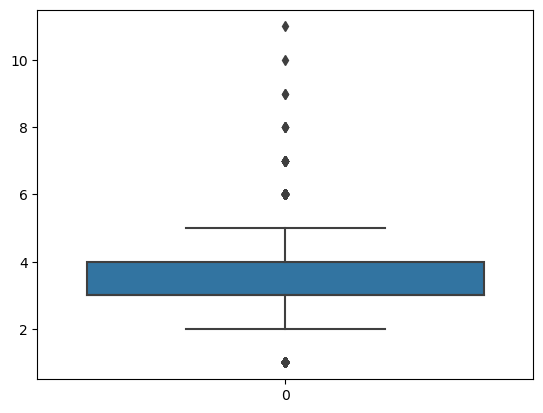

sqft_lot


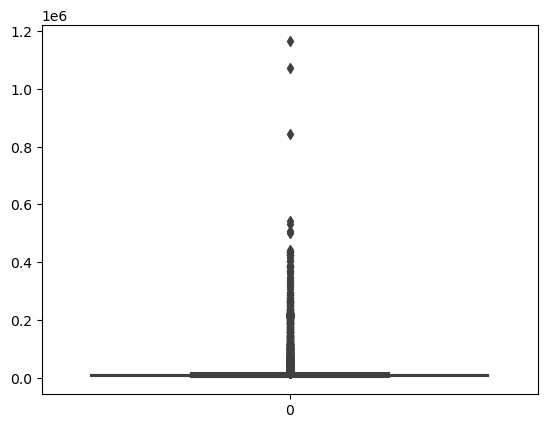

sqft_above


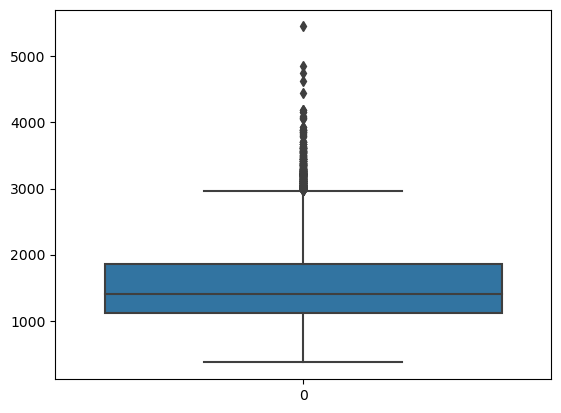

sqft_basement


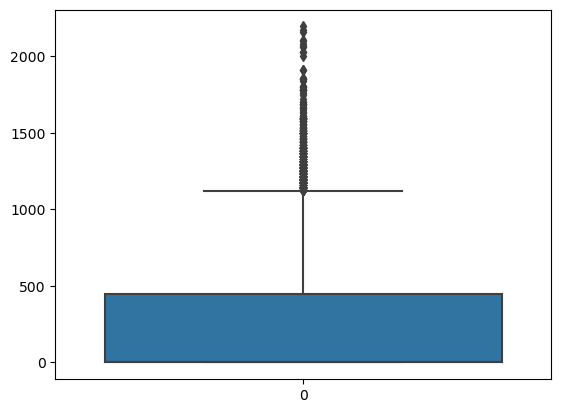

yr_built


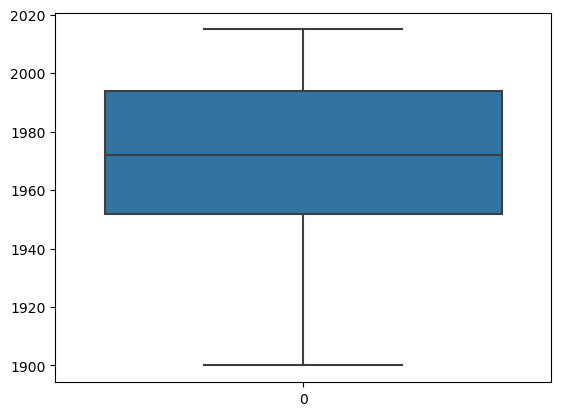

sqft_living15


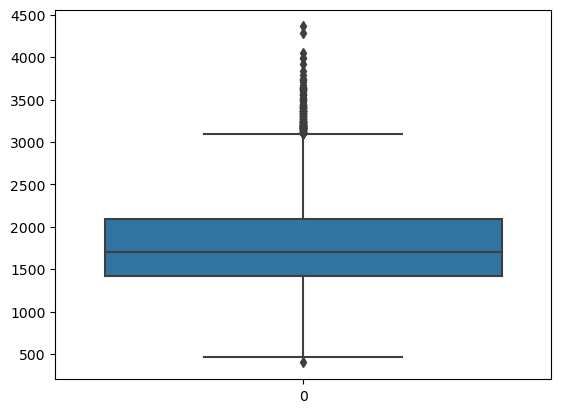

sqft_lot15


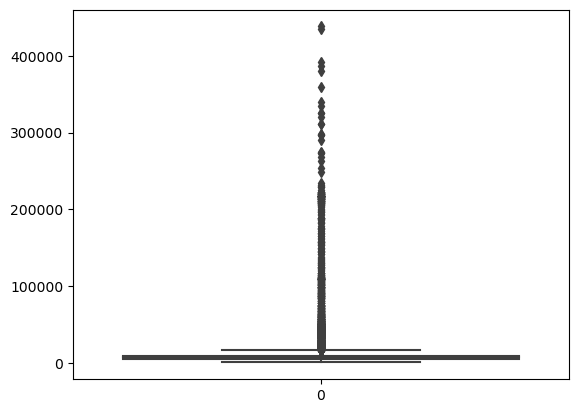

In [15]:
numerical_for_outls = numerical.drop(columns=["id", "sqft_living","price"])
for i in numerical_for_outls.columns:
    print(i)
    sns.boxplot(data_filtered[i])
    plt.show()

In [16]:
def remove_outliers(dataframe, columns):
    for col in columns:
        Q1 = dataframe[col].quantile(0.25)
        Q3 = dataframe[col].quantile(0.75)
        IQR = Q3 - Q1
        
        index_to_drop = dataframe[((dataframe[col] < (Q1 - 1.5 * IQR)) | (dataframe[col] > (Q3 + 1.5 * IQR)))].index

        dataframe = dataframe.drop(index_to_drop)
    
    return dataframe


In [17]:
data_filtered["price"] = price
cols = numerical_for_outls.columns
data_filtered = remove_outliers(data_filtered,cols)

In [18]:
data_filtered.shape

(13144, 91)

In [19]:
X = data_filtered.drop(columns="price")
y = data_filtered["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_train_scaled = y_train.apply(lambda x: np.log(x) if x > 0 else 0)
y_test_scaled = y_test.apply(lambda x: np.log(x) if x > 0 else 0)

lm = LinearRegression()
lm.fit(X_train_scaled, y_train_scaled)

predictions = lm.predict(X_test_scaled)

print("R2:", lm.score(X_test_scaled, y_test_scaled))
print("MAE:", mean_absolute_error(predictions, y_test_scaled))
print("RMSE:", mean_squared_error(predictions, y_test_scaled, squared=False))

R2: -6.9306996050659e+22
MAE: 1790999012.5123205
RMSE: 91831280335.81003


7. I will try some exhaustive feature selection before checking statistical significance and data importance

In [20]:
sfs = SFS(lm, k_features="best", forward=True, floating=False, cv=5, scoring="r2")
sfs.fit(X_train_scaled, y_train_scaled)

print("Selected Features:", sfs.k_feature_names_)

accuracy = sfs.k_score_
print("Accuracy:", accuracy)
sfs_df = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
sfs_df["avg_score"] = sfs_df["avg_score"].astype(float)
fig, ax = plt.subplots()
sfs_df.plot(kind="line", y="avg_score", ax=ax)
ax.set_xlabel("Number of Features")
ax.set_ylabel("Accuracy")
ax.set_title("Forward Selection Performance")
plt.show()

NameError: name 'sfs' is not defined

In [21]:
data_filtered.columns

Index(['bathrooms_0.75', 'bathrooms_1.0', 'bathrooms_1.25', 'bathrooms_1.5',
       'bathrooms_1.75', 'bathrooms_2.0', 'bathrooms_2.25', 'bathrooms_2.75',
       'bathrooms_3.0', 'bathrooms_3.25', 'bathrooms_3.5', 'bathrooms_3.75',
       'bathrooms_4.0', 'bathrooms_4.25', 'bathrooms_4.5', 'bathrooms_4.75',
       'bathrooms_5.0', 'bathrooms_5.25', 'bathrooms_5.5', 'bathrooms_5.75',
       'bathrooms_6.0', 'bathrooms_6.25', 'bathrooms_6.5', 'bathrooms_6.75',
       'bathrooms_7.5', 'bathrooms_7.75', 'bathrooms_8.0', 'floors_1.5',
       'floors_2.0', 'floors_2.5', 'floors_3.0', 'floors_3.5', 'waterfront_1',
       'view_1', 'view_2', 'view_3', 'view_4', 'condition_2', 'condition_4',
       'condition_5', 'grade_11', 'grade_12', 'grade_13', 'grade_3', 'grade_4',
       'grade_5', 'grade_6', 'grade_8', 'grade_9', 'renovated_1',
       'major_city_Bellevue', 'major_city_Black Diamond', 'major_city_Bothell',
       'major_city_Carnation', 'major_city_Duvall', 'major_city_Enumclaw',
       

In [22]:
zone = ['major_city_Bellevue', 'major_city_Black Diamond', 'major_city_Bothell',
       'major_city_Carnation', 'major_city_Duvall', 'major_city_Enumclaw',
       'major_city_Fall City', 'major_city_Federal Way', 'major_city_Issaquah',
       'major_city_Kenmore', 'major_city_Kent', 'major_city_Kirkland',
       'major_city_Maple Valley', 'major_city_Medina',
       'major_city_Mercer Island', 'major_city_North Bend',
       'major_city_Redmond', 'major_city_Renton', 'major_city_Sammamish',
       'major_city_Snoqualmie', 'major_city_Vashon', 'major_city_Woodinville']
rooms = ['bathrooms_0.75', 'bathrooms_1.0', 'bathrooms_1.25', 'bathrooms_1.5',
       'bathrooms_1.75', 'bathrooms_2.0', 'bathrooms_2.25', 'bathrooms_2.75',
       'bathrooms_3.0', 'bathrooms_3.25', 'bathrooms_3.5', 'bathrooms_3.75',
       'bathrooms_4.0', 'bathrooms_4.25', 'bathrooms_4.5', 'bathrooms_4.75',
       'bathrooms_5.0', 'bathrooms_5.25', 'bathrooms_5.5', 'bathrooms_5.75',
       'bathrooms_6.0', 'bathrooms_6.25', 'bathrooms_6.5', 'bathrooms_6.75',
       'bathrooms_7.5', 'bathrooms_7.75', 'bathrooms_8.0', 'floors_1.5',
       'floors_2.0', 'floors_2.5', 'floors_3.0', 'floors_3.5', 'bedrooms',]
extra = ['view_1', 'view_2', 'view_3', 'view_4','waterfront_1', 'renovated_1']
grades = ['condition_2', 'condition_4',
       'condition_5', 'grade_11', 'grade_12', 'grade_13', 'grade_3', 'grade_4',
       'grade_5', 'grade_6', 'grade_8', 'grade_9']
time = ['month_10', 'month_11', 'month_12', 'month_2', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'yr_built']
size = ['sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15',
       'sqft_lot15']
categs = [zone, rooms, extra, grades, time, size]

metrics = scoring_functions = {'r2': r2_score,'mse': mean_squared_error,'mae': mean_absolute_error}


In [23]:
def forward_feature_selection(data, target_column, categories, scoring_functions):

    X = data.drop(columns=[target_column])
    y = data[target_column]

    best_features = []
    best_scores = {}

    for r in range(1, len(categories) + 1):
        for category_combination in combinations(categories, r):
        
            combined_features = list(chain.from_iterable(category_combination))
        
            model = LinearRegression()
            sfs = SFS(model, k_features=min(30, len(combined_features)), forward=True, scoring='r2', cv=5)
            sfs.fit(X[combined_features], y)
            print("Selected Features:", sfs.k_feature_names_)

            model.fit(X[combined_features], y)

            scores = {}
            for scoring_name, scoring_function in scoring_functions.items():
                scores[scoring_name] = scoring_function(y, sfs.estimator.predict(X[combined_features]))

            if tuple(combined_features) not in best_scores or scores['r2'] > best_scores[tuple(combined_features)]['r2']:
                best_scores[tuple(combined_features)] = scores
                print("Selected Features:", sfs.k_feature_names_)
                print("Best features:", combined_features)
                print("Best scores:", scores)

    best_score = {'r2': -float('inf')}
    for features, scores in best_scores.items():
        if scores['r2'] > best_score['r2']:
            best_score = scores
            best_features = list(features)

    return best_features, best_score

In [ ]:
best_features, best_scores = forward_feature_selection(data_filtered, "price", categs, metrics)
print("Best Features:", best_features)
print("Best Scores:", best_scores)

In [24]:
selected_feats = ['major_city_Bellevue', 'major_city_Bothell', 'major_city_Enumclaw', 'major_city_Federal Way', 'major_city_Issaquah', 'major_city_Kent',
'major_city_Kirkland', 'major_city_Maple Valley', 'major_city_Mercer Island', 'major_city_Redmond', 'major_city_Renton', 'major_city_Sammamish',
'major_city_Woodinville', 'bathrooms_1.5', 'floors_3.0', 'bedrooms', 'condition_4', 'condition_5', 'grade_4', 'grade_5', 'grade_6',
'grade_8', 'grade_9', 'month_4', 'yr_built', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']

In [25]:
X = data_filtered[selected_feats]
y = data_filtered["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_train_scaled = y_train.apply(lambda x: np.log(x) if x > 0 else 0)
y_test_scaled = y_test.apply(lambda x: np.log(x) if x > 0 else 0)

lm = LinearRegression()
lm.fit(X_train_scaled, y_train_scaled)

predictions = lm.predict(X_test_scaled)

print("R2:", lm.score(X_test_scaled, y_test_scaled))
print("MAE:", mean_absolute_error(predictions, y_test_scaled))
print("RMSE:", mean_squared_error(predictions, y_test_scaled, squared=False))

R2: 0.5643569557730519
MAE: 0.1762317711930676
RMSE: 0.2302329581717508


In [41]:
def select_significance(features, target):
    results= {}

    for feature in features:
        t_statistic, p_value = stats.ttest_ind(feature, target)
        results[feature] = {'t_statistic': t_statistic, 'p_value': p_value}
        
    return results

In [42]:
select_significance(X_train_scaled, y_train_scaled)

TypeError: unhashable type: 'numpy.ndarray'

Feature: sqft_living15 Score: 0.07949794344270256
Feature: grade_8 Score: 0.057479175917947156
Feature: sqft_above Score: 0.05370416971166048
Feature: grade_6 Score: 0.04662767465060358
Feature: yr_built Score: 0.04222252454692432
Feature: major_city_Kent Score: 0.03746543960017368
Feature: sqft_lot15 Score: 0.03257464335758575
Feature: major_city_Federal Way Score: 0.030846389967361
Feature: bedrooms Score: 0.028199991168329497
Feature: grade_9 Score: 0.024811079908103828
Feature: major_city_Bellevue Score: 0.023869207811869853
Feature: major_city_Redmond Score: 0.023246003450480668
Feature: sqft_basement Score: 0.022855966475157086
Feature: sqft_lot Score: 0.02053713748431818
Feature: major_city_Kirkland Score: 0.020040499686708957
Feature: major_city_Maple Valley Score: 0.01642023839646023
Feature: major_city_Renton Score: 0.014054330471759746
Feature: grade_5 Score: 0.0140274860527283
Feature: major_city_Issaquah Score: 0.013337256892086202
Feature: major_city_Woodinville Score: 0.

Text(0.5, 1.0, 'Feature Importance Scores (Information Gain)')

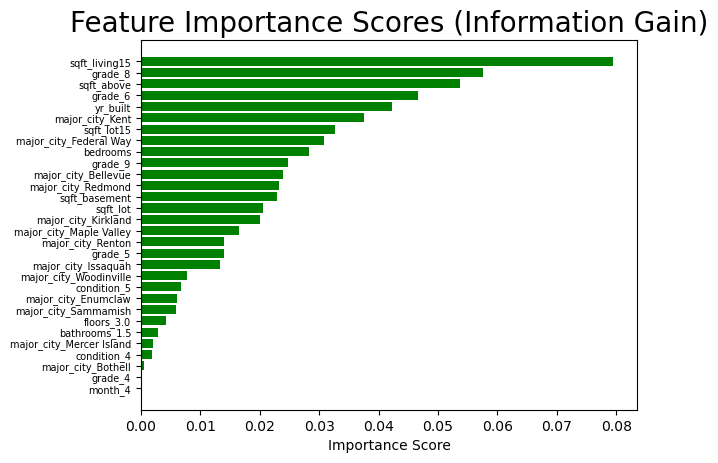

<Figure size 6000x4000 with 0 Axes>

In [38]:
ig = mutual_info_regression(X, y)

feature_scores = {}
for i in range(len(X.columns)):
    feature_scores[X.columns[i]] = ig[i]

sorted_features = sorted(feature_scores.items(), key=lambda x: x[1], reverse=True)

for feature, score in sorted_features:
    print("Feature:", feature, "Score:", score)

fig, ax = plt.subplots()
fig = plt.figure(figsize=(60, 40))
y_pos = np.arange(len(sorted_features))
ax.barh(y_pos, [score for feature, score in sorted_features], align="center", color = "green")
ax.set_yticks(y_pos)
ax.set_yticklabels([feature for feature, score in sorted_features], fontsize=7)
ax.invert_yaxis()
ax.set_xlabel("Importance Score", fontsize = 10)
ax.set_title("Feature Importance Scores (Information Gain)", fontsize = 20)